# Classes

In [1]:
ncell = 200
nlstm = 2
ndense = 2

#######################################################################################################
### 1. scaler class                                                                                 ###
#######################################################################################################
def interpolation(A, val):
    A_m = np.insert(A, 0, 0, 1)
    n1 = A_m.shape[1]
    if A.ndim == 2:
        y_interp = np.zeros((A_m.shape[0], (n1 - 1) * val))
    else:
        y_interp = np.zeros((A_m.shape[0], (n1 - 1) * val, A_m.shape[2]))
    for j in range(n1-1):
        for k in range(val):
            y_interp[:, j*val + k] = (A_m[:, j+1] - A_m[:, j])/val * k + A_m[:, j]
    return y_interp

def add_scalar(rec3D, scaler_val):
    n1 = rec3D.shape[0]
    if scaler_val.ndim == 1:
        scaler_val = scaler_val.reshape(scaler_val.shape[0], 1)
    for i in range(scaler_val.shape[1]):
        scaler_array = np.zeros((rec3D.shape[0], rec3D.shape[1]))
        for j in range(n1):
            scaler_array[j, :] = scaler_val[j, i]
        rec3D = np.insert(rec3D, 0, scaler_array, 2)
    return rec3D
############# End of input_creator #############


#######################################################################################################
### 2. Low Fidelity Model                                                                           ###
#######################################################################################################
class LowFidelityLSTM:
    def __init__(self, lr, loss_fun, n_ep, n_batch, val_split, mode):
        self.lr = lr
        self.n_ep = n_ep
        self.n_batch = n_batch
        self.val_split = val_split
        self.mode = mode
        self.loss_fun = loss_fun

    def architecture(self, n_in, n_out):
        model = Sequential()
        model.add(LSTM(ncell, return_sequences=True, stateful=False, input_shape=(None, n_in)))
        model.add(LeakyReLU(alpha=0.2))
        for h in range(nlstm-1):
            model.add(LSTM(ncell, return_sequences=True, stateful=False))
            model.add(LeakyReLU(alpha=0.2))
        for h in range(ndense-1):
            model.add(Dense(ncell))
            model.add(Activation('relu'))
        model.add(Dense(n_out))
        return model


    def training(self, X, Y):
        lr = self.lr
        n_ep = self.n_ep
        n_batch = self.n_batch
        val_split = self.val_split
        mode = self.mode
        loss_fun = self.loss_fun

        scaler_X = MinMaxScaler(feature_range=(-1, 1))
        scaler_y = MinMaxScaler(feature_range=(-1, 1))

        if mode == 0:
            X_flatten = np.reshape(X, [X.shape[0]*X.shape[1], X.shape[2]])
            X_flatten_map = scaler_X.fit_transform(X_flatten)
            y_flatten = np.reshape(Y, [Y.shape[0]*Y.shape[1], Y.shape[2]])
            y_flatten_map = scaler_y.fit_transform(y_flatten)
        elif mode == 1:
            X_flatten = X.flatten()
            X_flatten_map = scaler_X.fit_transform(X_flatten.reshape(X_flatten.shape[0], 1))
            y_flatten = Y.flatten()
            y_flatten_map = scaler_y.fit_transform(y_flatten.reshape(y_flatten.shape[0], 1))

        xtrain = np.reshape(X_flatten_map, [X.shape[0], X.shape[1], X.shape[2]])
        ytrain = np.reshape(y_flatten_map, [Y.shape[0], Y.shape[1], Y.shape[2]])

        model = self.architecture(X.shape[2], Y.shape[2])

        #adam = Adam(learning_rate = lr, decay = ld)
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=lr,
            decay_steps=1000,
            decay_rate=0.9)
        optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        model.compile(loss = loss_fun, optimizer=optim, metrics=['accuracy'])
        history = model.fit(xtrain, ytrain, validation_split = val_split ,batch_size = n_batch, shuffle=True, epochs = n_ep, verbose=0,
                  callbacks=[TqdmCallback(verbose=0)])

        self.model = model
        self.scl_x = scaler_X
        self.scl_y = scaler_y
        self.history = history
        return None


    def testing(self, X):
        model = self.model
        scl_x = self.scl_x
        scl_y = self.scl_y
        mode = self.mode

        if mode == 0:
            X_flatten = np.reshape(X, [X.shape[0]*X.shape[1], X.shape[2]])
            X_flatten_map = scl_x.transform(X_flatten)
        elif mode == 1:
            X_flatten = X.flatten()
            X_flatten_map = scl_x.transform(X_flatten.reshape(X_flatten.shape[0], 1))

        xtest = np.reshape(X_flatten_map, [X.shape[0], X.shape[1], X.shape[2]])

        yhat = model.predict(xtest)

        if mode == 0:
            ypred = np.reshape(yhat, (yhat.shape[0] * yhat.shape[1], yhat.shape[2]))
            ypred_m = scl_y.inverse_transform(ypred)
        elif mode == 1:
            ypred = yhat.flatten()
            ypred_m = scaler_y.inverse_transform(ypred.reshape(ypred.shape[0], 1))

        ypred_m = np.reshape(ypred_m, [yhat.shape[0], yhat.shape[1]*yhat.shape[2]])
        return ypred_m
  
    def model_bias_weight(self):
        model = self.model
        return model
###############      End of Low Fidelity model       ###############


#######################################################################################################
### 5. Reshaping into Windows                                                                       ###
#######################################################################################################
def windowing_m(X, win_size):
    #if X.ndim == 3:
    #    X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
    n1 = X.shape[0]
    n2 = X.shape[1]
    win = int(n2/win_size)
    X_modif = X[:, 0:win*win_size]
    if X.ndim == 3:
        X_win = np.reshape(X_modif, (n1, win, win_size, X.shape[2]))
    else:
        X_win = np.reshape(X_modif, (n1, win, win_size))
    return X_win
####### End of windowing #############

# Reading Data

In [2]:
import os
import numpy as np
import csv
from scipy import signal, integrate
from scipy.io import loadmat

fpath = os.getcwd()

tr_dur = 1
dt_tr = 0.01
t_tr = np.arange(0.0, tr_dur - dt_tr, dt_tr)
tr_n = 30
EQ_indx = [1] #The first earthquake record is uploaded in the provided data
te_n = len(EQ_indx)

### reading train and test data from Matlab file
fpath_tr = fpath + f'/SSI-Beam/n{tr_n}-NewRV'

data = loadmat(fpath_tr + '/data.mat')

samples_tr = data['samples_tr']
UG_tr = data['UG_tr']
ytr = data['resp_tr']

samples_te = data['samples_te']
UG_te = {}
resp_FEM = {}
for i, val in enumerate(EQ_indx):
    UG_te[i] = data[f'UG_te_EQ{val}']
    resp_FEM[i] = data[f'resp_FEM_EQ{val}']

# Train Model

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from pdb import set_trace as bp
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Activation, Dropout, LeakyReLU
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
import time
from random import shuffle
from tqdm.keras import TqdmCallback
import random
from keras.utils.vis_utils import plot_model


tic = time.time()

### defining input data of the model
no_rv = 5    #number of random variables
win_w = 50
windowsize = int(len(t_tr)/win_w) #test/train window size
no_ep = 500    #epoch value
no_bs = 15    #batch_size value
lss = 'mse'    #cost function
learn_rate = 0.002
qoi = 40

xtr_r = windowing_m(UG_tr, windowsize)

ytr_r = ytr.reshape(ytr.shape[0], ytr.shape[1] * ytr.shape[2])
ytr_m = windowing_m(ytr_r, windowsize * qoi)

if no_rv == 1:
    xtr_m = np.copy(xtr_r)
else:
    xtr_m = add_scalar(xtr_r, samples_tr)

LSTM_base = LowFidelityLSTM(learn_rate, lss, no_ep, no_bs, 0.3, 0)
LSTM_tr = LSTM_base.training(xtr_m, ytr_m)

toc = time.time()

2023-08-08 14:31:39.506647: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 14:31:39.542608: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 14:31:39.543118: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 14:31:40.157756: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-08 14:31:40.824349: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Do

0epoch [00:00, ?epoch/s]

2023-08-08 14:31:41.551632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-08 14:31:41.552983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-08 14:31:41.553831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

# Plotting the loss curves

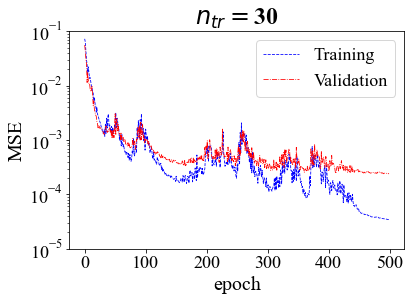

In [4]:
plt.rcParams['font.family'] = 'Times New Roman'
xfont = {'fontsize': 20}
titlefont = {'fontsize': 24, 'fontweight': 'bold'}

history = LSTM_base.history

lss = np.array([history.history['loss'][0], history.history['loss'][-1], history.history['val_loss'][0], history.history['val_loss'][-1]])

plt.plot(history.history['loss'], 'b--', lw=0.8)
plt.plot(history.history['val_loss'], 'r-.', lw=0.8)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(['Training', 'Validation'], fontsize=18)
plt.xlabel('epoch', **xfont)
plt.xticks(np.arange(0, 501, 100))
plt.ylabel('MSE', **xfont)
plt.ylim([1e-5, 1e-1])
plt.yscale('log')
plt.title(r'$n_{tr}=$' + f'{tr_n}', **titlefont)
#plt.savefig(fpath_tr + f'/Indices-EQ-{tr_dur}s/Loss-Curve-n{tr_n}-dur{tr_dur}-w{win_w}-QoI{qoi}-Layer{nlstm}-{ndense}Dense-Cells{ncell}.png', bbox_inches='tight', format='png', dpi=300)
plt.show()

# Testing

In [5]:
y_pr = {}
for i in range(te_n):
    xte_r = windowing_m(UG_te[i], windowsize)
    
    if no_rv == 1:
        xte_m = np.copy(xte_r)
    else:
        xte_m = add_scalar(xte_r, samples_te[i:i+1])
    
    y_pr[i] = LSTM_base.testing(xte_m)
    y_pr[i] = y_pr[i].reshape(1, y_pr[i].shape[1]//(qoi), qoi)

2023-08-08 14:33:26.548078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-08 14:33:26.549230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-08 14:33:26.550371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 877ms/step


# Plotting responses of test data

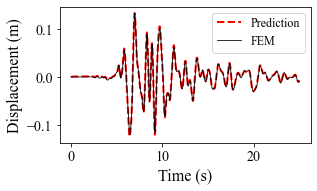

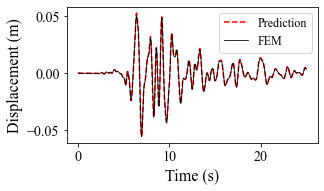

In [6]:
xfont = {'fontsize': 16}
annotfont = {'fontsize': 14}
plt.rcParams["figure.figsize"]=(4.5, 2.5)

i = 0
j = 0

t_FEM = np.arange(0, 25, 0.0004)
t_pr = np.arange(0, 25, 0.01)
plt.plot(t_pr[:y_pr[i].shape[1]], y_pr[i][0, :, j], 'r--', lw=2)
plt.plot(t_FEM[:len(resp_FEM[i])], resp_FEM[i][:, j], 'k', lw=0.8)

plt.ylabel('Displacement (m)', **xfont)
plt.xlabel('Time (s)', **xfont)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(['Prediction', 'FEM'], fontsize=12)
#plt.savefig(fpath_tr + f'/EQ{i+1}-Time-History-Horiz.png', bbox_inches='tight', format='png', dpi=300)
plt.show()

plt.rcParams["figure.figsize"]=(4.5, 2.5)

i = 0
j = 20

t_FEM = np.arange(0, 58.06, 0.0004)
t_pr = np.arange(0, 58.06, 0.01)
plt.plot(t_pr[:y_pr[i].shape[1]], y_pr[i][0, :, j], 'r--', lw=1.5)
plt.plot(t_FEM[:len(resp_FEM[i])], resp_FEM[i][:, j], 'k', lw=0.8)
plt.ylabel('Displacement (m)', **xfont)
plt.xlabel('Time (s)', **xfont)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(['Prediction', 'FEM'], fontsize=12)
#plt.savefig(fpath_tr + f'/EQ{i+1}-Time-History-Vert.png', bbox_inches='tight', format='png', dpi=300)
plt.show()